In [1]:
!nvidia-smi

Sun Sep 13 19:44:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%cd /content/drive/My Drive/AI4E/Ls9

/content/drive/My Drive/AI4E/Ls9


In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 6.5MB/s 


In [3]:
from numpy import asarray
from numpy import load
from numpy import expand_dims
from numpy import savez_compressed
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from keras.models import load_model
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
from os import listdir
from os.path import isdir

In [4]:
#trích xuất mặt từ ảnh
def extract_face(filename, required_size=(160, 160)):
	image = Image.open(filename) #đọc ảnh từ file
	image = image.convert('RGB') #đổi sang RGB
	pixels = asarray(image) #Biểu diễn dạng vector

	detector = MTCNN() #sử dụng Multi-task Cascaded Convolutional Networks
	results = detector.detect_faces(pixels) #tìm gương mặt trong ảnh
	x1, y1, width, height = results[0]['box'] #xác định góc trên, góc dưới, chiều dài, rộng của gương mặt
	x1, y1 = abs(x1), abs(y1) #lấy giá trị tuyệt đối
	x2, y2 = x1 + width, y1 + height #toạ độ dưới
	face = pixels[y1:y2, x1:x2] #trích xuất gương mặt từ ảnh

	#đặt lại kích thước của ảnh
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
 
	return face_array

#trích xuất gương mặt của các ảnh trong file
def load_faces(directory):
	faces = list()
	for filename in listdir(directory):
		path = directory + filename
		face = extract_face(path)
		faces.append(face)
  
	return faces

#trích xuất gương mặt và gán nhãn từ bộ dataset
def load_dataset(directory):
	X, y = list(), list()
	for filename in listdir(directory):
		path = directory + filename + '/'
		if not isdir(path): #kiểm tra đường dẫn
			continue
		faces = load_faces(path)
		labels = [filename for _ in range(len(faces))] #tạo nhãn
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), filename))
		X.extend(faces)
		y.extend(labels)
  
	return asarray(X), asarray(y)

trainX, trainy = load_dataset('/content/drive/My Drive/AI4E/Ls9/dataset/train/')
testX, testy = load_dataset('/content/drive/My Drive/AI4E/Ls9/dataset/val/')

savez_compressed('/content/drive/My Drive/AI4E/Ls9/nameData.npz', trainX, trainy, testX, testy) #lưu dữ liệu gương mặt dạng mảng numpy vào file

>loaded 51 examples for class: thang
>loaded 30 examples for class: thuy
>loaded 33 examples for class: nam
>loaded 20 examples for class: khang
>loaded 32 examples for class: thai
>loaded 31 examples for class: thoai
>loaded 30 examples for class: hieu
>loaded 46 examples for class: huy
>loaded 45 examples for class: vinh
>loaded 6 examples for class: nam
>loaded 5 examples for class: hieu
>loaded 5 examples for class: thang
>loaded 5 examples for class: thoai
>loaded 5 examples for class: vinh
>loaded 5 examples for class: khang
>loaded 5 examples for class: thai
>loaded 5 examples for class: thuy
>loaded 5 examples for class: huy


In [6]:
# tạo face embeddings
def get_embedding(model, face_pixels):
	face_pixels = face_pixels.astype('float32')
	#chuẩn hoá các giá trị pixels
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std #lấy trung bình
	samples = expand_dims(face_pixels, axis=0)
	yhat = model.predict(samples) #dùng mô hình để dự đoán và trích xuất embedding

	return yhat[0]

data = load('/content/drive/My Drive/AI4E/Ls9/nameData.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

#Dùng model FaceNet Keras của Hiroki Taniai
model = load_model('/content/drive/My Drive/AI4E/Ls9/facenet_keras.h5')

#Chuyển dữ liệu trong tập train sang embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)

#Chuyển dữ liệu trong tập test sang embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)

#lưu dữ liệu dạng mảng numpy vào file
savez_compressed('/content/drive/My Drive/AI4E/Ls9/embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (318, 160, 160, 3) (318,) (46, 160, 160, 3) (46,)
(46, 128)


In [7]:
data = load('/content/drive/My Drive/AI4E/Ls9/nameData.npz')
testX_faces = data['arr_2']

data = load('/content/drive/My Drive/AI4E/Ls9/embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

#Chuẩn hoá vector theo L2
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

#Chuyển nhãn thành số
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

#Dùng SVM
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=99.686, test=100.000


Nam.jpg
Expected: Nam
Predicted: nam (99.991)


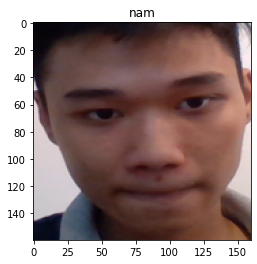

Nam (2).jpg
Expected: Nam
Predicted: nam (95.399)


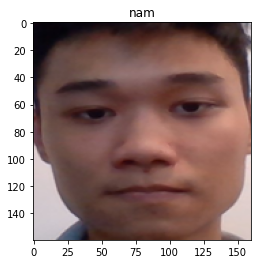

Nam (3).jpg
Expected: Nam
Predicted: nam (100.000)


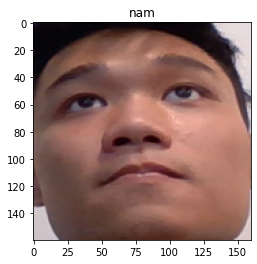

Nam (4).jpg
Expected: Nam
Predicted: nam (100.000)


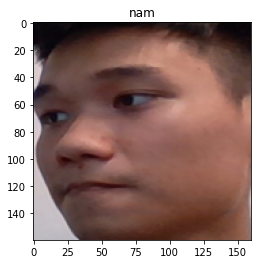

Nam (5).jpg
Expected: Nam
Predicted: nam (100.000)


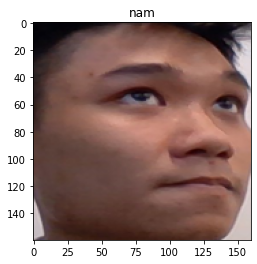

Khang.jpg
Expected: Khang
Predicted: khang (99.789)


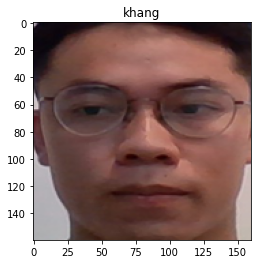

Khang (2).jpg
Expected: Khang
Predicted: khang (99.785)


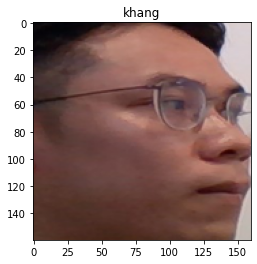

Khang (3).jpg
Expected: Khang
Predicted: khang (99.998)


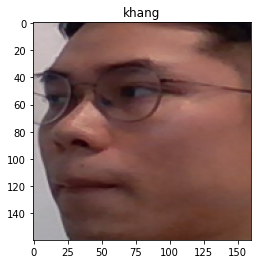

Khang (4).jpg
Expected: Khang
Predicted: khang (100.000)


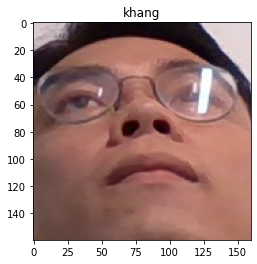

Vinh.jpg
Expected: Vinh
Predicted: vinh (59.435)


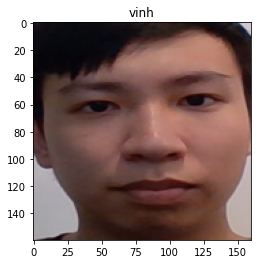

Vinh (2).jpg
Expected: Vinh
Predicted: vinh (100.000)


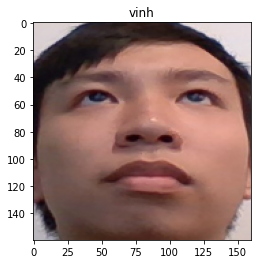

Vinh (3).jpg
Expected: Vinh
Predicted: vinh (100.000)


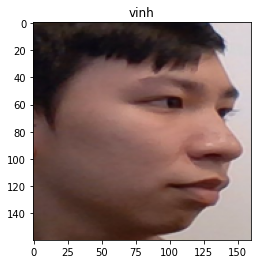

Vinh (4).jpg
Expected: Vinh
Predicted: vinh (100.000)


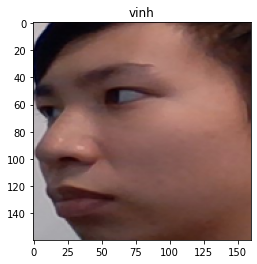

Hiếu.jpg
Expected: Hiếu
Predicted: hieu (100.000)


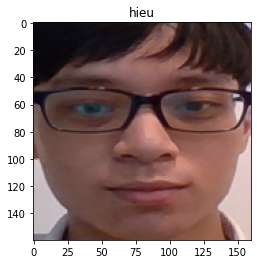

Hiếu (2).jpg
Expected: Hiếu
Predicted: hieu (100.000)


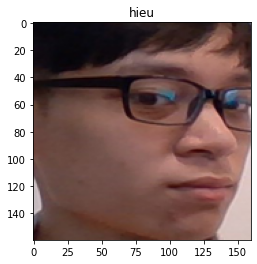

Hiếu (3).jpg
Expected: Hiếu
Predicted: hieu (100.000)


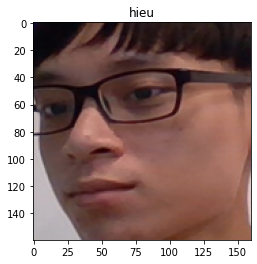

Hiếu (4).jpg
Expected: Hiếu
Predicted: hieu (100.000)


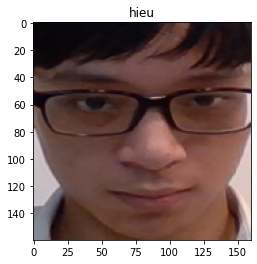

Hiếu (5).jpg
Expected: Hiếu
Predicted: hieu (100.000)


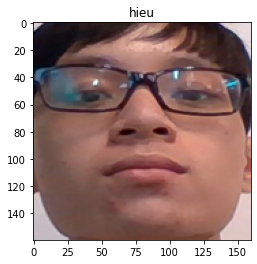

Thoại.jpg
Expected: Thoại
Predicted: thoai (100.000)


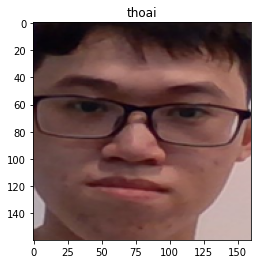

Thoại (2).jpg
Expected: Thoại
Predicted: thoai (100.000)


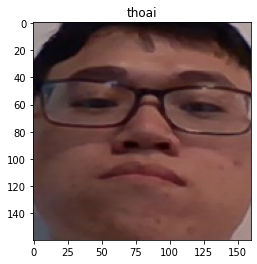

Thoại (3).jpg
Expected: Thoại
Predicted: thoai (100.000)


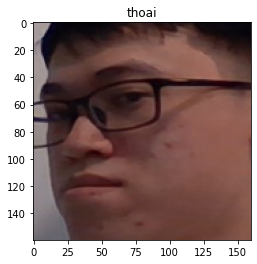

Thoại (4).jpg
Expected: Thoại
Predicted: thoai (100.000)


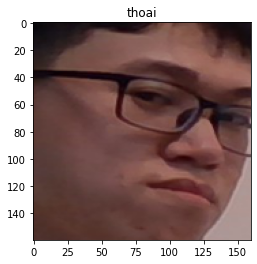

Thúy.jpg
Expected: Thúy
Predicted: thuy (100.000)


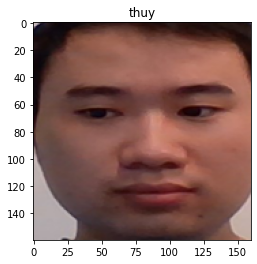

Thúy (2).jpg
Expected: Thúy
Predicted: thuy (100.000)


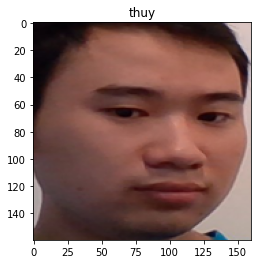

Thúy (3).jpg
Expected: Thúy
Predicted: thuy (100.000)


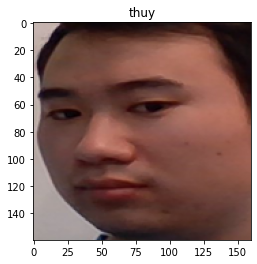

Thúy (4).jpg
Expected: Thúy
Predicted: thuy (100.000)


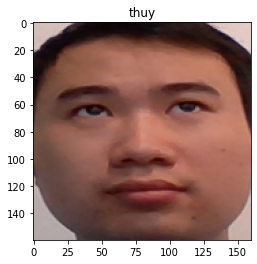

Thúy (5).jpg
Expected: Thúy
Predicted: thuy (100.000)


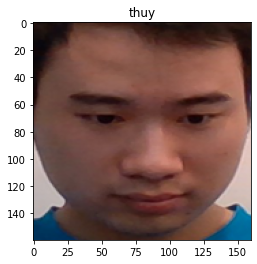

Thúy (6).jpg
Expected: Thúy
Predicted: thuy (100.000)


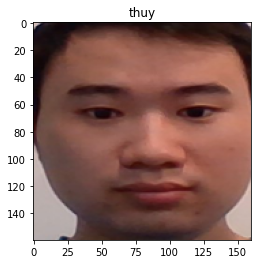

Thắng.jpg
Expected: Thắng
Predicted: thang (100.000)


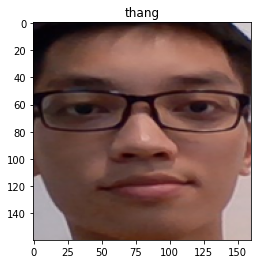

Thắng (2).jpg
Expected: Thắng
Predicted: thang (100.000)


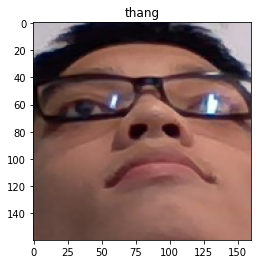

Thắng (3).jpg
Expected: Thắng
Predicted: thang (100.000)


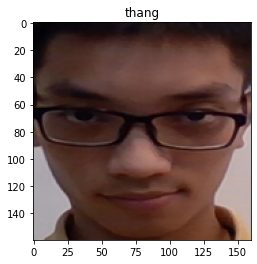

Thắng (4).jpg
Expected: Thắng
Predicted: thang (100.000)


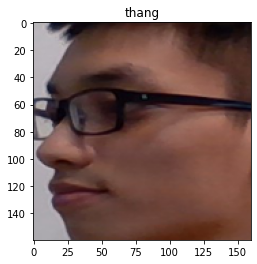

Thắng (5).jpg
Expected: Thắng
Predicted: thang (100.000)


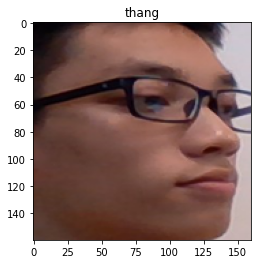

Thái.jpg
Expected: Thái
Predicted: thai (100.000)


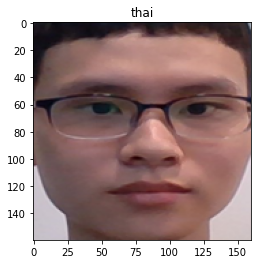

Thái (2).jpg
Expected: Thái
Predicted: thai (100.000)


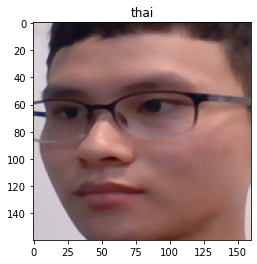

Thái (3).jpg
Expected: Thái
Predicted: thai (100.000)


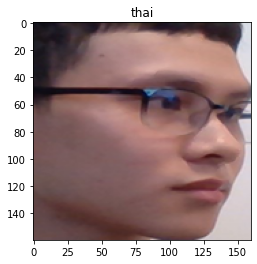

Thái (4).jpg
Expected: Thái
Predicted: thai (100.000)


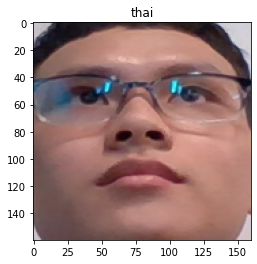

Thái (5).jpg
Expected: Thái
Predicted: thai (100.000)


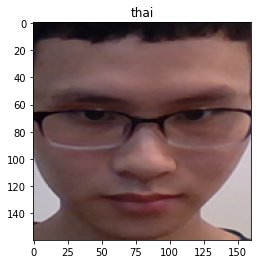

Huy.jpg
Expected: Huy
Predicted: huy (100.000)


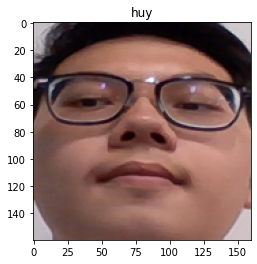

Huy (2).jpg
Expected: Huy
Predicted: huy (100.000)


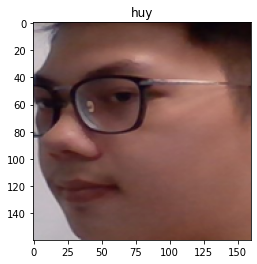

Huy (3).jpg
Expected: Huy
Predicted: huy (97.644)


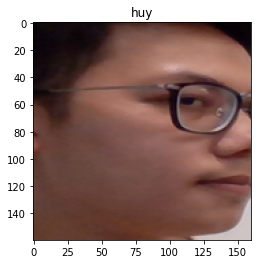

Correct: 41
Incorrect: 0
Unknown: 0


In [13]:
folder = '/content/drive/My Drive/AI4E/Ls9/cw2/'

model_fk = load_model('/content/drive/My Drive/AI4E/Ls9/facenet_keras.h5')
threshold = 50

for filename in listdir(folder):
    img = folder + filename
    face_pixels = extract_face(img)
    face_emb = get_embedding(model_fk, face_pixels)

    #Dự đoán gương mặt
    samples = expand_dims(face_emb, axis=0)
    yhat_class = model.predict(samples)
    yhat_prob = model.predict_proba(samples)

    #Gán tên
    class_index = yhat_class[0]
    class_probability = yhat_prob[0, class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)

    print(filename)
    expected_names = filename[:(len(filename) - 4)].split(' ')
    print('Expected: %s' % expected_names[0])
    if class_probability < threshold:
        print('Predicted: unknown')
        title = 'unknown'
    else:
        print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
        title = '%s' % predict_names[0]
        
    pyplot.imshow(face_pixels)
    pyplot.title(title)
    pyplot.show()

In [1]:
print("Correct: 41")
print("Incorrect: 0")
print("Unknown: 0")

Correct: 41
Incorrect: 0
Unknown: 0
